# Recitation 11 - Built-in Transformer Model
TA: shiwei.tan@rutgers.edu

A detailed version of transformer implementation is available here:
https://github.com/hyunwoongko/transformer

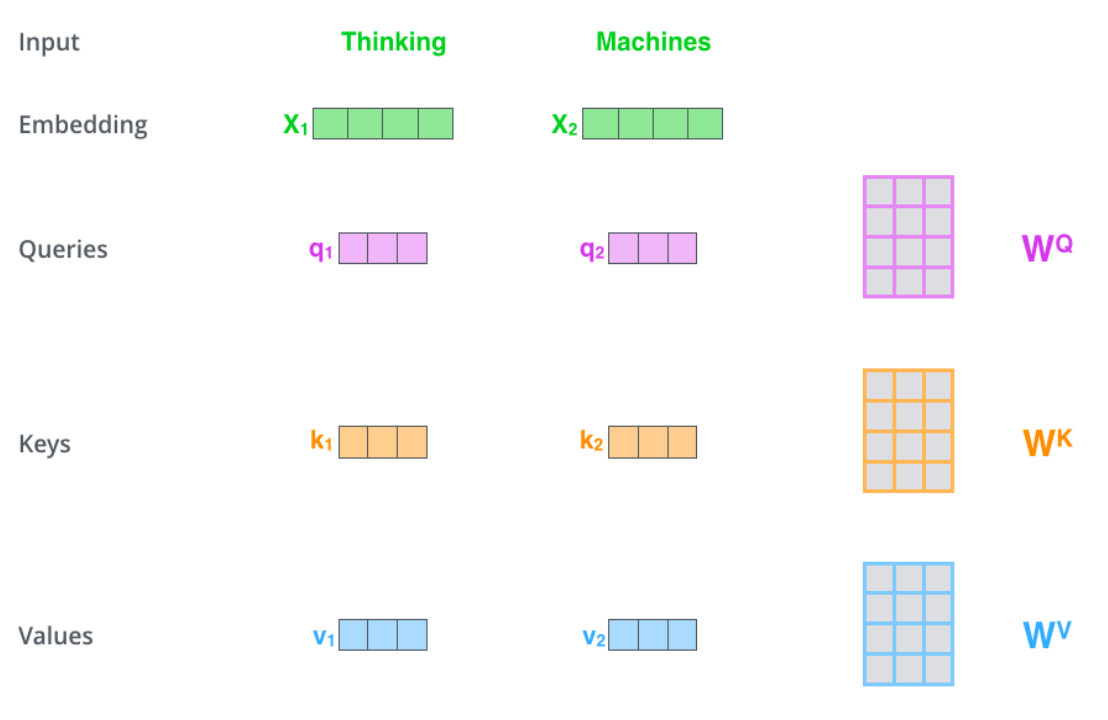

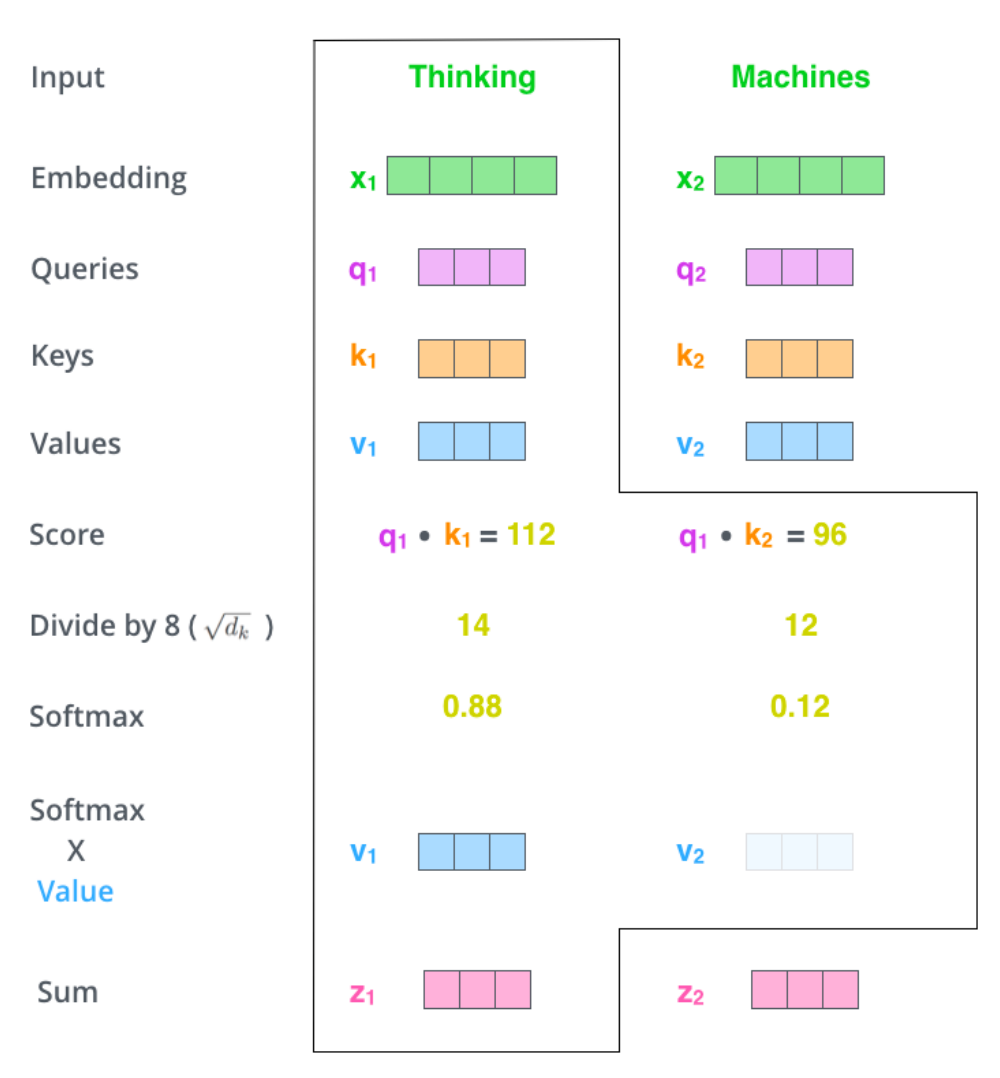

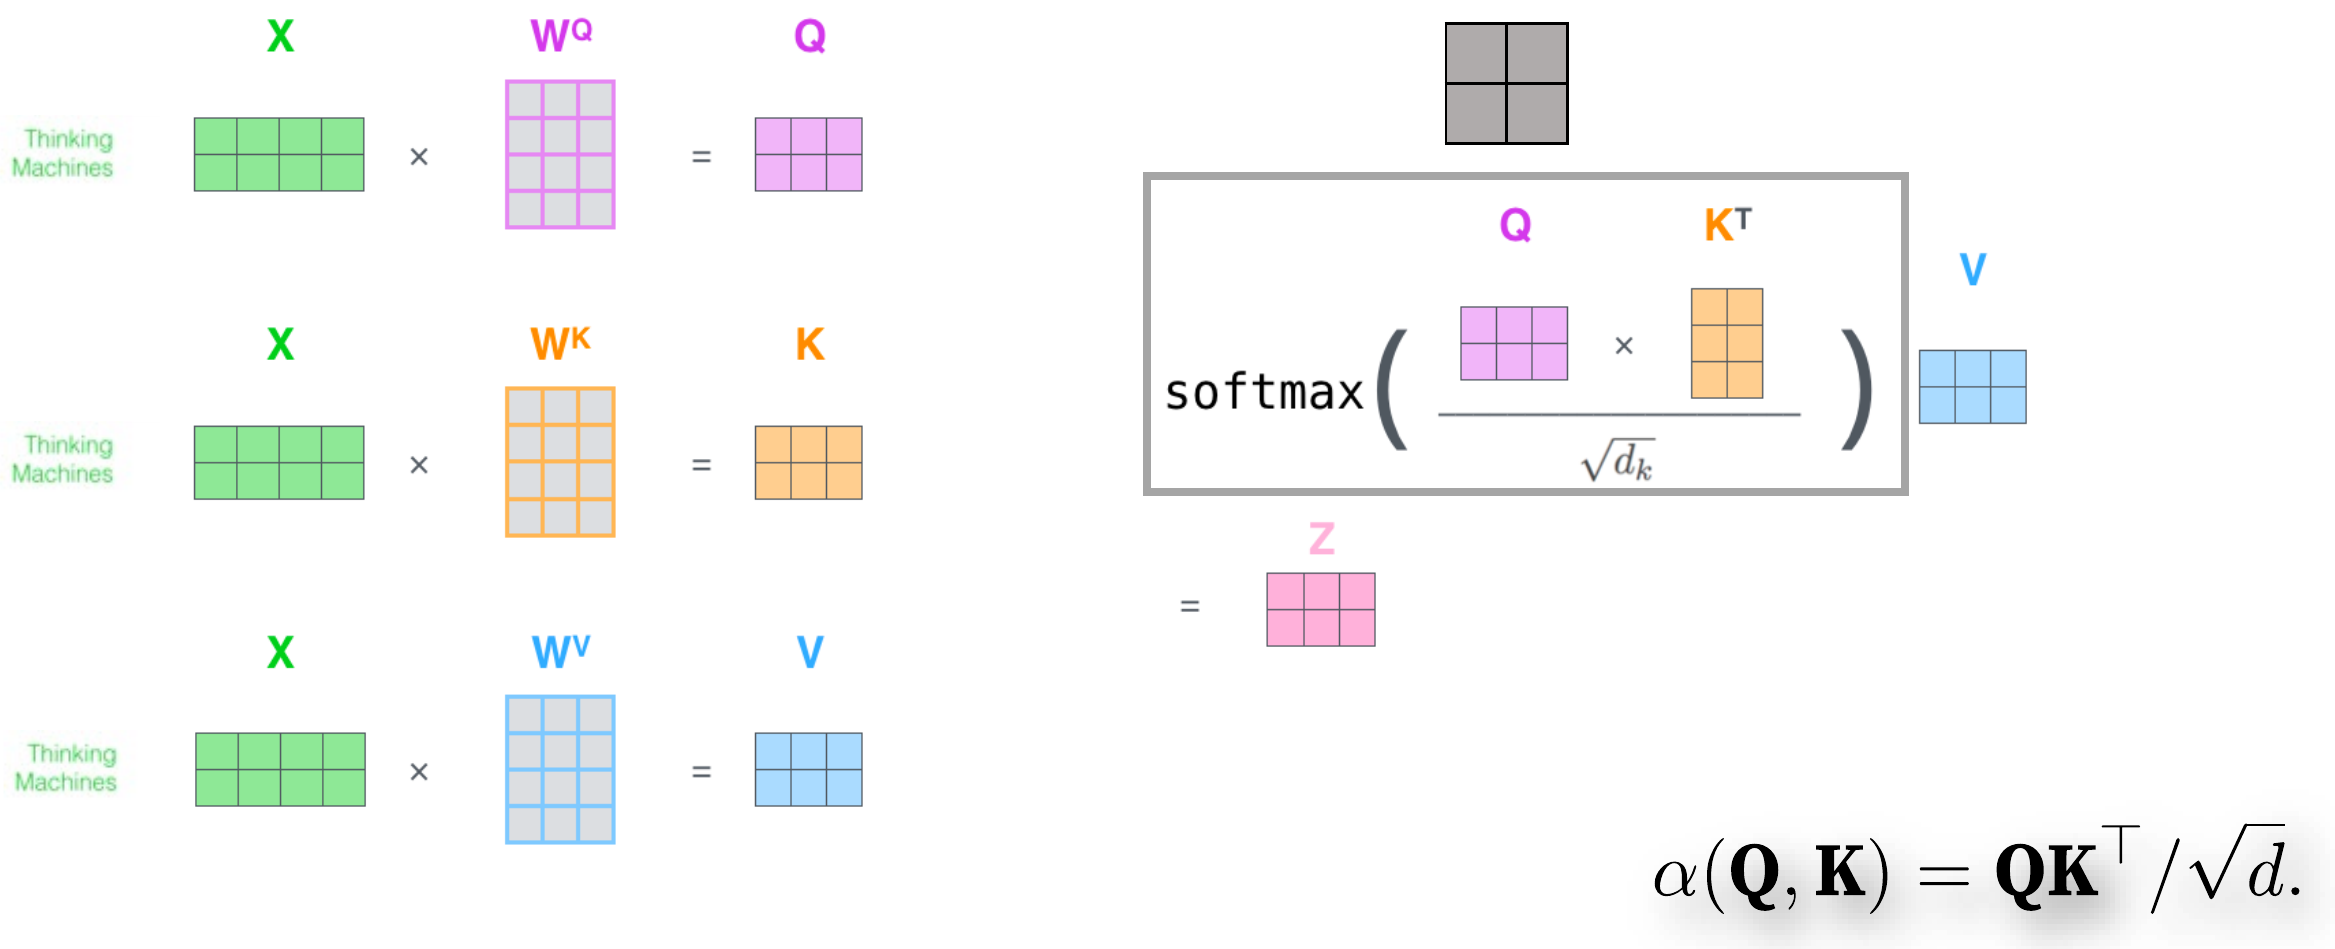

In [ ]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
import torch.optim as optim
import bs4
import urllib.request

webpage = str(urllib.request.urlopen("https://www.gutenberg.org/cache/epub/345/pg345.txt").read())
soup = bs4.BeautifulSoup(webpage)

text = soup.get_text()
text = text.replace("\\r\\n", '\n')
print(text[0:1000])

tokens = [ "[UNK]" ] + list(set(text))
print("Tokens:", tokens[0:10])

def get_random_substring(text, length):
  start_point = random.randint(0, len( text ) - 1 - length - 1)
  # We want to get a sequence of length 'length', and the next character
  substring = text[start_point:start_point + length]
  next_token = text[start_point + length]

  return substring, next_token

print( get_random_substring(text, 100) )

def generate_batch(text, length, batch_size, token_dict):
  x_index_lists = []
  y_index_list = []

  for i in range( batch_size ):
    substring, next_token = get_random_substring( text, length )
    x_index_lists.append( [ token_dict.index( c ) for c in substring ]  )
    y_index_list.append( token_dict.index( next_token ))

  return torch.LongTensor(x_index_lists), torch.LongTensor(y_index_list)

generate_batch(text, length = 10, batch_size = 5, token_dict = tokens)

b'\xef\xbb\xbfThe Project Gutenberg eBook of Dracula
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Dracula

Author: Bram Stoker

Release date: October 1, 1995 [eBook #345]
                Most recently updated: November 12, 2023

Language: English

Credits: Chuck Greif and the Online Distributed Proofreading Team


*** START OF THE PROJECT GUTENBERG EBOOK DRACULA ***




                                DRACULA

                                  _by_

                              Bram Stoker

                        [Illustration: colophon]

                                NEW YORK



(tensor([[61, 66, 35, 28, 69, 19, 61, 27, 69, 68],
         [59, 68, 19, 61, 68, 55,  2, 61, 77, 66],
         [54, 28, 61, 55, 28, 51, 69, 27, 69, 86],
         [ 5, 28, 55,  2, 86, 54, 71, 69, 82, 61],
         [61, 55, 28, 51, 69, 27, 69, 86,  8, 66]]),
 tensor([61, 58,  8, 54, 21]))

In [ ]:
class TokenTransformerModel(nn.Module):
  def __init__(self, token_dictionary, embedding_size):
    super(TokenTransformerModel, self).__init__()

    self.tokens = token_dictionary
    self.n_tokens = len( self.tokens )
    self.dim = embedding_size

    self.embedding = nn.Embedding( self.n_tokens, self.dim, max_norm=True)
    self.embedding_dropout = nn.Dropout( 0.1 )

    self.transformer = torch.nn.Transformer(d_model=self.dim, nhead=4, num_encoder_layers=3,
                                            num_decoder_layers=3, dim_feedforward=100, dropout=0.1, batch_first=True, bias=True)

    self.logit_layer = nn.Linear( in_features = self.dim, out_features = self.n_tokens )

  def forward(self, input_tensor, masking = False):

    ######################################################################################
    # Randomly mask some tokens
    embedded = input_tensor.clone()
    batch_size, seq_length = embedded.shape

    if masking:
      for i in range( batch_size ):
        for t in range( seq_length ):
          if random.random() <= 0.15:
            embedded[i, t] = 0
    ######################################################################################

    embedded = self.embedding( embedded )
    batch_size, seq_length, feature_count = embedded.shape

    ############################################################################################
    # Add positional embedding
    pos_embedding = torch.zeros( seq_length, feature_count )
    div_term = torch.exp(torch.arange(0, feature_count, 2) * (-np.log(1000.0) / feature_count))

    for i in range( seq_length ):
      pos_embedding[i, 0:feature_count:2] = torch.sin(i * div_term)
      pos_embedding[i, 1:feature_count:2] = torch.cos(i * div_term)

    embedded = embedded + pos_embedding
    embedded = self.embedding_dropout( embedded )
    ############################################################################################

    transformed = self.transformer( src = embedded, tgt = embedded )
    logits = self.logit_layer( transformed[:, -1, :] )
    return logits
    ################################################################################################

In [ ]:
transformer_model = TokenTransformerModel(tokens, embedding_size = 60)
batch_size = 7
x_batch, y_batch = generate_batch(text, 35, batch_size, tokens)
transformer_model( x_batch, masking = True ).shape

torch.Size([7, 87])

In [ ]:
def predict_next_character(model, substring, tokens):
  indices = torch.LongTensor( [ [ tokens.index(c) for c in substring ] ] )
  next_token_logits = model( indices ).detach()[0]
  next_token_probabilities = torch.nn.Softmax( dim = 0 )( next_token_logits )
  next_token_probabilities = np.asarray( next_token_probabilities )

  next_character = random.choices( tokens, weights = next_token_probabilities, k = 1 )
  return next_character[0]

def extend_prompt(model, prompt, tokens, character_count):
  model.eval()
  output = prompt
  for i in range( character_count ):
    next_character = predict_next_character(model, output, tokens)
    output += next_character
  return output

extend_prompt(transformer_model, "Dracula, where is my money? ", tokens, 40)

"Dracula, where is my money? E'4-FYgE[pqx?\\N;Q1N 4s2E6SNsAyE4*QS/BQl1"

In [ ]:
transformer_model = TokenTransformerModel(tokens, embedding_size = 60)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam( transformer_model.parameters(), lr = 0.001 )

batch_size = 100

for epoch in range(100):
  print("Training Epoch", epoch)

  transformer_model.train()

  for batch in range(100):
    seq_length = random.randint(1,20)
    x_batch, y_batch =  generate_batch(text, seq_length, batch_size, tokens)
    optimizer.zero_grad()
    logits = transformer_model( x_batch, masking = True )
    loss = loss_function( logits, y_batch )
    loss.backward()
    optimizer.step()

  print( loss.item() )
  print("########################################################")
  print( extend_prompt(transformer_model, "Mina, ", tokens, 40) )
  print("########################################################")

Training Epoch 0
3.3516716957092285
########################################################
Mina, se sdisecoo,\is 6l.onm dmoyfaose huao wi
########################################################
Training Epoch 1
3.1945106983184814
########################################################
Mina, pg mixd \  tt n .ynbCxooLstmvxudd mra   
########################################################
Training Epoch 2
3.1736841201782227
########################################################
Mina, tei neeasr gae,drIh 2,xehh wsu  s  fh2ae
########################################################
Training Epoch 3
3.2615251541137695
########################################################
Mina, rm cerI iiotTeaemxdwM ehhw an r  fosi eu
########################################################
Training Epoch 4
3.1438112258911133
########################################################
Mina, to bhid9.o yig.e   td
dia sea
rei \fw  a
########################################################
Training Epoch 